In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import logging
import pypsa
import os.path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd

# from make_summary import assign_carriers
from _helpers import configure_logging, mock_snakemake
from constants import PLOT_COST_UNITS, PLOT_CAP_UNITS,PLOT_SUPPLY_UNITS
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
from plot_network import plot_capex_map, plot_map, plot_energy_map
from _plot_utilities import fix_network_names_colors, rename_techs

logger = logging.getLogger(__name__)


In [5]:

snakemake = mock_snakemake(
    "plot_network",
    snakefile_path=os.path.abspath("../"),
    opts="ll",
    topology="current+Neighbor",
    pathway="exponential175",
    planning_horizons="2060",
    heating_demand="positive",
)

configure_logging(snakemake, logger=logger)
config = snakemake.config
tech_colors = config["plotting"]["tech_colors"]


ntw_path = snakemake.input.network

# ntw_path = "/home/ivanra/documents/PyPSA-China-PIK/results/version-0325.175.1H/postnetworks/positive/postnetwork-ll-current+Neighbor-exponential175-2060.nc"
# ntw_path = "/home/ivanra/downloads/PaperResultsXiaowei_networks/postnetwork-ll-current+Neighbor-exponential175-2060.nc"
n = pypsa.Network(ntw_path)

INFO:pypsa.io:Imported network ntwk_2060.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores


In [6]:
fix_network_names_colors(n, config)

/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/_plot_utilities.py:142: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.carriers.color.fillna(NAN_COLOR, inplace=True)


In [7]:
n.global_constraints

,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,
co2_limit_2060,primary_energy,NaN,co2_emissions,<=,0.0,-214.437036


# plot map

In [8]:
from plot_network import plot_capex_map, plot_map

## plot capex

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/plot_network.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/plot_network.py:338: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


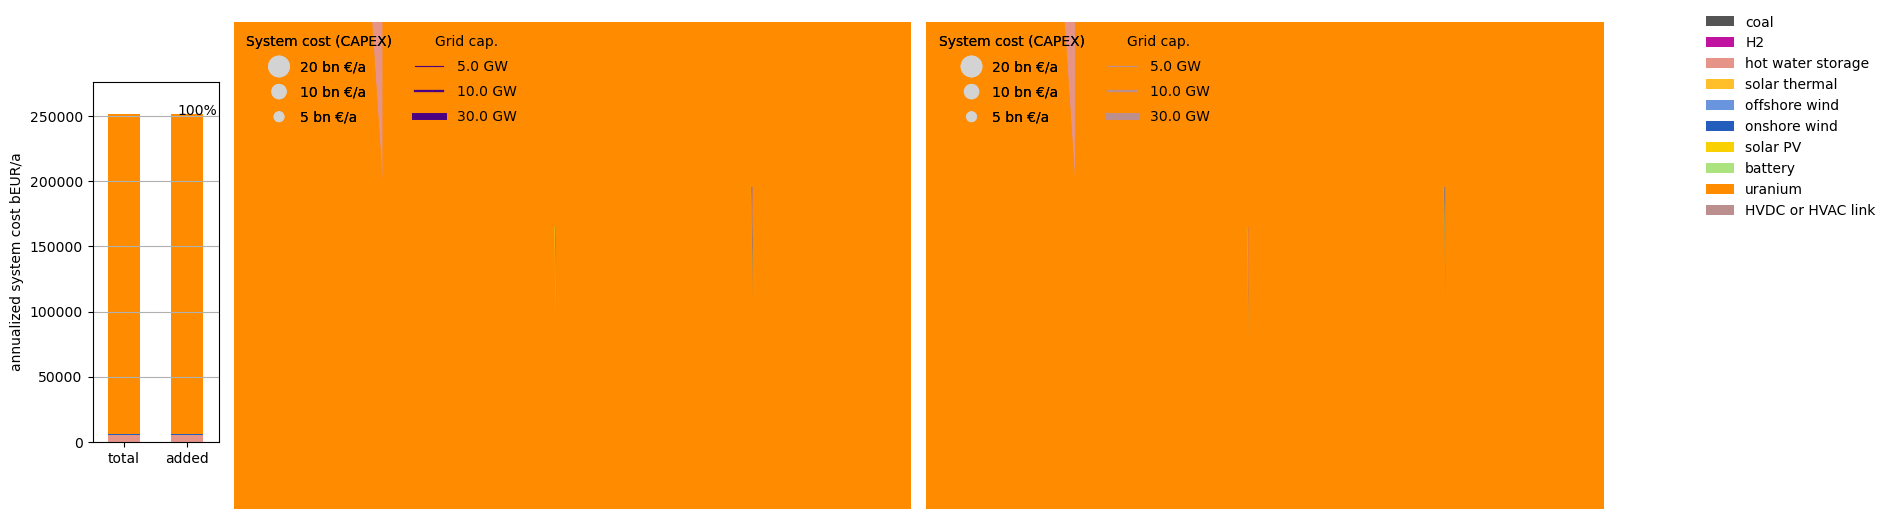

In [9]:
ax = plot_capex_map(n, 2060, snakemake.config["costs"]["discountrate"], config["plotting"])

# TODO: check costs map with stats

In [10]:
from _plot_utilities import assign_location
from plot_network import plot_map
opts = config["plotting"]
plot_ntwk = n.copy()
assign_location(plot_ntwk)
cpx = plot_ntwk.statistics.capex(groupby=pypsa.statistics.get_bus_and_carrier)
cpx2 = cpx.droplevel(0)

In [11]:
anhui_stats = cpx.unstack().groupby(level=1).sum().loc["Anhui"]
anhui_stats.index = anhui_stats.index.map(rename_techs)
anhui_stats.where(anhui_stats > 0).dropna().sort_index()

carrier
Battery Storage         6.077863e+08
Coal Power Plant        2.669465e+08
Heat Pump               7.277098e+11
Hydrogen Storage        1.926122e+11
Nuclear                 1.864077e+12
Onshore Wind            4.332906e+08
Pumped Hydro Storage    2.701888e+08
Solar                   4.009210e+08
resistive heater        1.975969e+11
Name: Anhui, dtype: float64

## plot electricy generation map

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/plot_network.py:470: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/plot_network.py:431: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


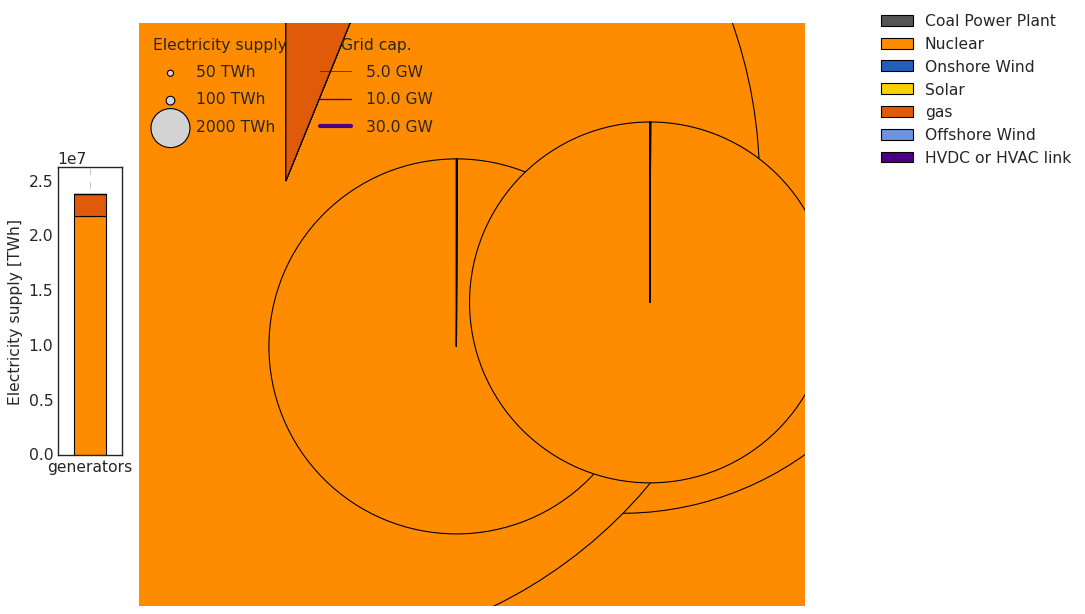

In [12]:
from plot_network import plot_energy_map
from _plot_utilities import set_plot_style
set_plot_style(
    style_config_file= os.path.abspath("../../config/plotting_styles/network_map.mplstyle"),
    #snakemake.config["plotting"]["network_style_config_file"],
    base_styles=["classic", "seaborn-v0_8-white"],
)
plot_energy_map(n,config["plotting"], carrier="AC")

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


<GeoAxes: >

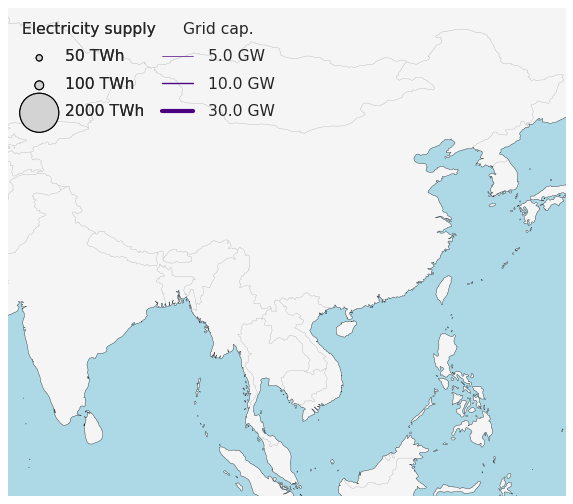

In [13]:
plot_h2_ntwk = n.copy()
carrier = "H2"
# avoid cluttering the plot
plot_h2_ntwk.buses.drop(plot_h2_ntwk.buses.index[plot_h2_ntwk.buses.carrier != carrier], inplace=True)
plot_h2_ntwk.links.drop(
    plot_h2_ntwk.links.index[plot_h2_ntwk.links.carrier != carrier],
    inplace=True,
)

supply_pies = plot_h2_ntwk.statistics.supply(
        groupby=pypsa.statistics.get_bus_and_carrier, bus_carrier=carrier, comps=["Generator"]
    ).droplevel(0)

# get all carrier types
carriers_list = supply_pies.index.get_level_values(1).unique()
carriers_list = carriers_list.tolist()

# TODO make line handling nicer
line_lower_threshold = 500.0
line_upper_threshold = 1e4
# Make figure
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(opts["energy_map"]["figsize"])
# get colors
bus_colors = plot_h2_ntwk.carriers.loc[plot_h2_ntwk.carriers.nice_name.isin(carriers_list), "color"]
bus_colors.rename(opts["nice_names"], inplace=True)
# Add the total costs
bus_size_factor = opts["energy_map"]["bus_size_factor"]/1e2
linewidth_factor = opts["energy_map"]["linewidth_factor"]*1
edges = pd.concat([plot_h2_ntwk.lines.s_nom_opt, plot_h2_ntwk.links.p_nom_opt])
edge_widths = (
    edges
    .clip(line_lower_threshold, edges.max())
    .replace(line_lower_threshold, 0)
)
preferred_order = pd.Index(opts["preferred_order"])
reordered = preferred_order.intersection(bus_colors.index).append(
    bus_colors.index.difference(preferred_order)
)

plot_map(
    plot_h2_ntwk,
    tech_colors=plot_h2_ntwk.carriers.color,
    edge_widths=edge_widths / linewidth_factor,
    bus_colors=bus_colors.loc[reordered],
    bus_sizes=supply_pies / 1,
    edge_colors="indigo",
    ax=ax,
    edge_unit_conv=PLOT_CAP_UNITS,
    bus_unit_conv=PLOT_SUPPLY_UNITS,
    add_legend=False,
    **opts["energy_map"],
)

## plot capacity

## plot cost

## Interactive plot map

In [14]:

import numpy as np
# make names and link sizes, make sure we only plot AC, DC & statiosn
ac_links = n.links[n.links.carrier == "AC"]
colors = n.links.index.to_series().apply(lambda x: 'black' if 'ext' in x else 'pink')
widths = np.log(n.links.p_nom_opt + 3) / 2
widths[~widths.index.isin(ac_links.index)] = 0
widths[widths.index.str.contains('reversed')] = 0
names = n.links.copy()
names["name"] = names.index.values
names.loc[~names.index.isin(ac_links.index), "p_nom_opt"] = ""
names.loc[~names.index.isin(ac_links.index), "name"] = ""
buses = n.buses.copy()
buses["name"] = buses.apply(lambda x: f"{x.name}" if x.carrier == "AC" or x.carrier=="stations" else "", axis=1)
buses["sizes"] = buses.apply(lambda x:10 if x.carrier == "AC" or x.carrier=="stations" else 0, axis=1)
buses["colors"] = buses.apply(lambda x: "black" if x.carrier == "AC" else "red", axis=1)
buses.carrier.unique()
ax = n.iplot(link_colors=colors, link_widths=widths, link_text = names.p_nom_opt.astype(str) + names.name, bus_text=buses.name, bus_sizes=buses.sizes, bus_colors=buses.colors)

/p/tmp/ivanra/anaconda/ipykernel_1353066/1096144582.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  names.loc[~names.index.isin(ac_links.index), "p_nom_opt"] = ""


In [15]:
n.links[(n.links.length != 0)&(n.links.index.str.find("reversed")<0)].p_nom_opt.sort_values(ascending=False).round(2).head(20)

Series([], Name: p_nom_opt, dtype: float64)

### extendable lines

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


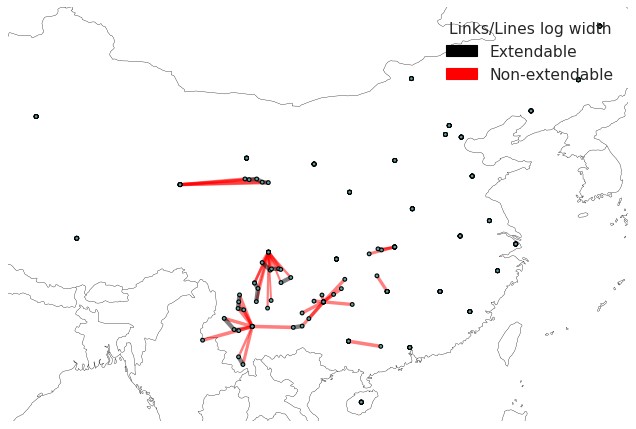

In [16]:

fig, ax = plt.subplots(1, 1, figsize=(10, 10),subplot_kw={"projection":ccrs.PlateCarree()})
def width(x):
    return np.log10(x/1e6).where(x>1,0)
n.plot(ax = ax,link_colors=n.links.p_nom_extendable.apply(lambda x: "red" if not x else "black"),line_colors=n.lines.s_nom_extendable.apply(lambda x: "red" if not x else "black"), link_widths= width(n.links.p_nom_opt) , line_widths=width(n.lines.s_nom_opt), link_alpha=0.5)
# Create custom legend
import matplotlib.patches as mpatches
extendable_patch = mpatches.Patch(color='black', label='Extendable')
non_extendable_patch = mpatches.Patch(color='red', label='Non-extendable')
ax.legend(handles=[extendable_patch, non_extendable_patch], title = "Links/Lines log width")

# Shadow prices & prices

In [17]:
from make_summary import make_summaries
summaries = make_summaries({("exp175-paper", 2060):ntw_path})

INFO:make_summary:Make summary for scenario ('exp175-paper', 2060), using /p/tmp/ivanra/PyPSA-China-PIK/results/v-0.1_IRtest001/overnight_pthw-exponential175_topo-current+Neighbor_proj-positive/postnetworks/ntwk_2060.nc


INFO:pypsa.io:Imported network ntwk_2060.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/make_summary.py:436: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(n.generators.loc[gens, "bus"], axis=1)
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/make_summary.py:436: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(n.generators.loc[gens, "bus"], axis=1)
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/make_summary.py:436: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(n.generators.loc[gens, "bus"], axis=1)
/p/tmp/ivanra/PyPSA-China-PIK/workflow/scripts/make_summary.py:436: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(n.

In [18]:
n.statistics.supply(bus_carrier="AC")["Generator"]


carrier
Coal Power Plant    3.411189e+07
Nuclear             2.189939e+13
Offshore Wind       4.897689e+07
Onshore Wind        8.417114e+09
Solar               9.642011e+08
gas                 2.004585e+12
dtype: float64

In [19]:
n.statistics.supply(bus_carrier="AC")["Generator"].sum()

23913435049872.53

In [20]:
n.statistics.transmission(bus_carrier="AC")

Series([], dtype: float64)

In [21]:
4.275996e+08/1.122624e+10*100



3.808929793056268

In [22]:
4.955233e+08*2

991046600.0

In [23]:
n.statistics.energy_balance(bus_carrier="AC")

component    carrier               bus_carrier
Generator    Coal Power Plant      AC             3.411189e+07
             Nuclear               AC             2.189939e+13
             Offshore Wind         AC             4.897689e+07
             Onshore Wind          AC             8.417114e+09
             Solar                 AC             9.642011e+08
             gas                   AC             2.004585e+12
Load         -                     AC            -1.625553e+10
StorageUnit  Pumped Hydro Storage  AC            -4.240668e+07
Link         Battery Storage       AC            -8.749924e+09
             Coal Power Plant      AC             4.012026e+07
             Heat Pump             AC            -1.719733e+13
             Hydrogen Storage      AC            -4.971349e+12
             battery discharger    AC             8.399930e+09
             gas                   AC             4.926593e+08
             resistive heater      AC            -1.728962e+12
        

In [24]:
eb = n.statistics.energy_balance()
eb_reordered = eb.reorder_levels([2, 0, 1])
eb_reordered.sort_index(inplace=True)
eb_reordered.rename(index={"AC": "Transmission Losses"}, level=2)

bus_carrier       component    carrier             
AC                Generator    Coal Power Plant        3.411189e+07
                               Nuclear                 2.189939e+13
                               Offshore Wind           4.897689e+07
                               Onshore Wind            8.417114e+09
                               Solar                   9.642011e+08
                               gas                     2.004585e+12
                  Link         Battery Storage        -8.749924e+09
                               Coal Power Plant        4.012026e+07
                               Heat Pump              -1.719733e+13
                               Hydrogen Storage       -4.971349e+12
                               battery discharger      8.399930e+09
                               gas                     4.926593e+08
                               resistive heater       -1.728962e+12
                               stations                3.199054e

In [25]:
eb_reordered = eb.reorder_levels([2, 0, 1])
eb_reordered.sort_index(inplace=True)
eb_reordered.rename(index={"AC": "Transmission Losses"}, level=2)
header = pd.Series(("exp175-paper", 2060), index=pd.MultiIndex.from_tuples([("pathway", "", ""), ("planning_horizons", "", "")], names=['bus_carrier', 'component', 'carrier']))
df = pd.concat([header, eb_reordered], axis=0)
df.index.names = (None, None, None)

df.to_csv("energy_balance.csv", header=False)


In [26]:
df

pathway                                                          exp175-paper
planning_horizons                                                        2060
AC                 Generator    Coal Power Plant               34111886.23875
                                Nuclear                 21899385539288.277344
                                Offshore Wind                  48976890.85694
                                Onshore Wind                 8417114023.15545
                                Solar                         964201110.28965
                                gas                      2004585106673.713867
                   Link         Battery Storage              -8749924441.3228
                                Coal Power Plant               40120263.73044
                                Heat Pump              -17197328524930.150391
                                Hydrogen Storage        -4971348994935.591797
                                battery discharger           839

In [27]:
n.statistics.supply()["Generator"].sum()

23913836771131.996

In [28]:
n.statistics.withdrawal(bus_carrier="AC")

component    carrier             
Load         -                       1.625553e+10
StorageUnit  Pumped Hydro Storage    4.264119e+07
Link         Battery Storage         8.749924e+09
             Heat Pump               1.719733e+13
             Hydrogen Storage        4.971594e+12
             resistive heater        1.728962e+12
dtype: float64

In [29]:
n.statistics.withdrawal(bus_carrier="AC", groupby = pypsa.statistics.get_bus_carrier)

component    bus_carrier
Load         AC             1.625553e+10
StorageUnit  AC             4.264119e+07
Link         AC             2.390663e+13
dtype: float64

In [30]:
n.statistics.withdrawal()

component    carrier             
Load         -                       4.384873e+13
StorageUnit  Pumped Hydro Storage    4.264119e+07
Link         Battery Storage         8.749924e+09
             Coal Power Plant        1.008554e+08
             Heat Pump               1.719733e+13
             Hydrogen Storage        4.972085e+12
             Sabatier                3.728205e+12
             battery discharger      8.573142e+09
             gas                     9.776330e+11
             resistive heater        1.728962e+12
             stations                4.021972e+08
             water tanks             3.121813e+12
Store        Battery Storage         5.630991e+08
             Hydrogen Storage        6.239438e+08
             gas                     2.979797e+12
             stations                2.077128e+08
             water tanks             1.394993e+12
dtype: float64

In [31]:
n.statistics.transmission()

component  carrier 
Link       stations    1.880664e+08
Name: objective, dtype: float64

In [32]:
summaries["weighted_prices"].round(2)

pathway,exp175-paper
planning_horizons,2060
electricity,14.28
heat,28.31
H2,1.48
CO2 capture,NaN
gas,-9.22
biomass,NaN


In [33]:
n.global_constraints

,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,
co2_limit_2060,primary_energy,NaN,co2_emissions,<=,0.0,-214.437036


# CO2 emissions

<Axes: xlabel='snapshot'>

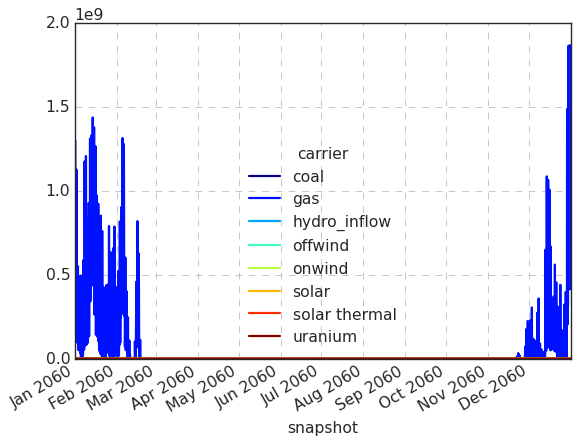

In [34]:
fig, ax = plt.subplots()
# calc the t resolved CO2 emissions from generators
((n.generators_t.p/ n.generators.efficiency)* n.generators.carrier.map(n.carriers.co2_emissions)).T.groupby(n.generators.carrier).sum().T.plot(ax =ax, cmap ="jet")

Text(0, 0.5, 'cum CO2 emissions [t]')

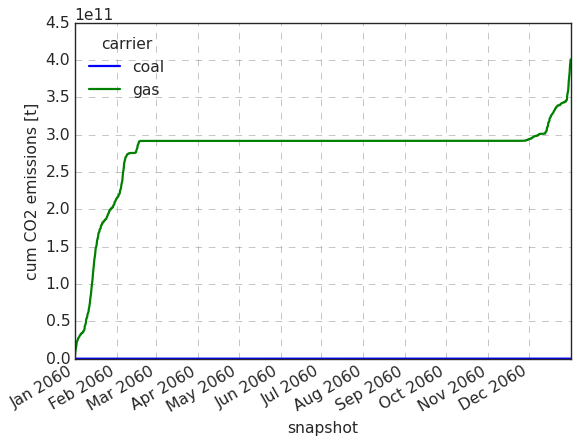

In [35]:
gen_emissions = ((n.generators_t.p/ n.generators.efficiency)* n.generators.carrier.map(n.carriers.co2_emissions)).T.groupby(n.generators.carrier).sum().T.cumsum()
fig, ax = plt.subplots()
gen_emissions.where(gen_emissions>0).dropna(axis=1, how="all").plot(ax=ax)
ax.set_ylabel("cum CO2 emissions [t]")


KeyError: "['CO2', 'CO2 capture', 'biomass'] not in index"

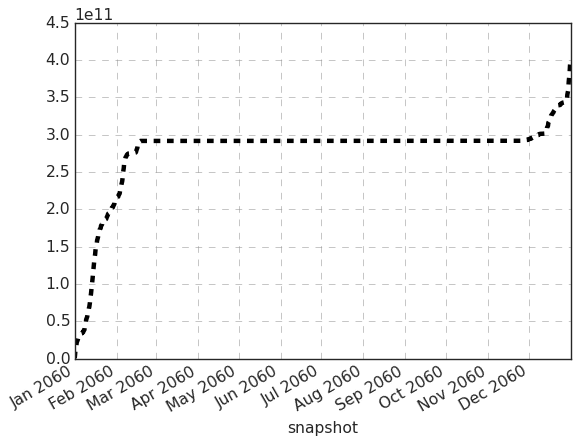

In [36]:
fig, ax = plt.subplots()
# calc the t resolved CO2 emissions from generators
((n.generators_t.p/ n.generators.efficiency)* n.generators.carrier.map(n.carriers.co2_emissions)).T.groupby(n.generators.carrier).sum().sum().T.cumsum().plot(ax =ax, label = "CO2 emissions (cum)", lw=4, c ="black", ls = "--")
n.stores_t.e.T.groupby(n.stores.carrier).sum().loc[["CO2","H2", "CO2 capture", "gas", "biomass"]].T.plot(lw=4, cmap ="jet", ax =ax)
ax.legend()
ax.semilogy()
ax.set_ylim(1e3,1e10)
ax.set_ylabel("carrier stock")

## CO2 capture
! beware the store is the difference :)

In [ ]:
stores = n.stores_t.e.T.groupby(n.stores.carrier).sum()
diff = stores.iloc[:, -1] -stores.iloc[:, 0]
co2_cap = stores.iloc[:, -1].loc[["CO2 capture"]].sum()
co2_cap


307248811.2752091

<Axes: xlabel='snapshot'>

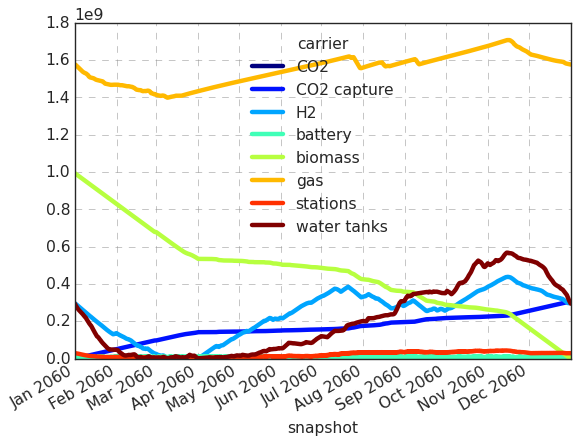

In [ ]:
n.stores_t.e.T.groupby(n.stores.carrier).sum().T.plot(lw=4, cmap ="jet")

# plot time series

In [37]:
from plot_time_series import plot_energy_balance

In [47]:
loads_ = n.loads_t.p
loads_[[c for c in loads_.columns if not "heat" in c]].sum().sum()*1e-6

16255.533374517941

In [48]:
loads_ = n.loads_t.p
loads_[[c for c in loads_.columns if  "heat" in c]].sum().sum()*1e-6

43832470.283128165

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1798: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, None)


Text(0.5, 1.0, 'Electricity Balance')

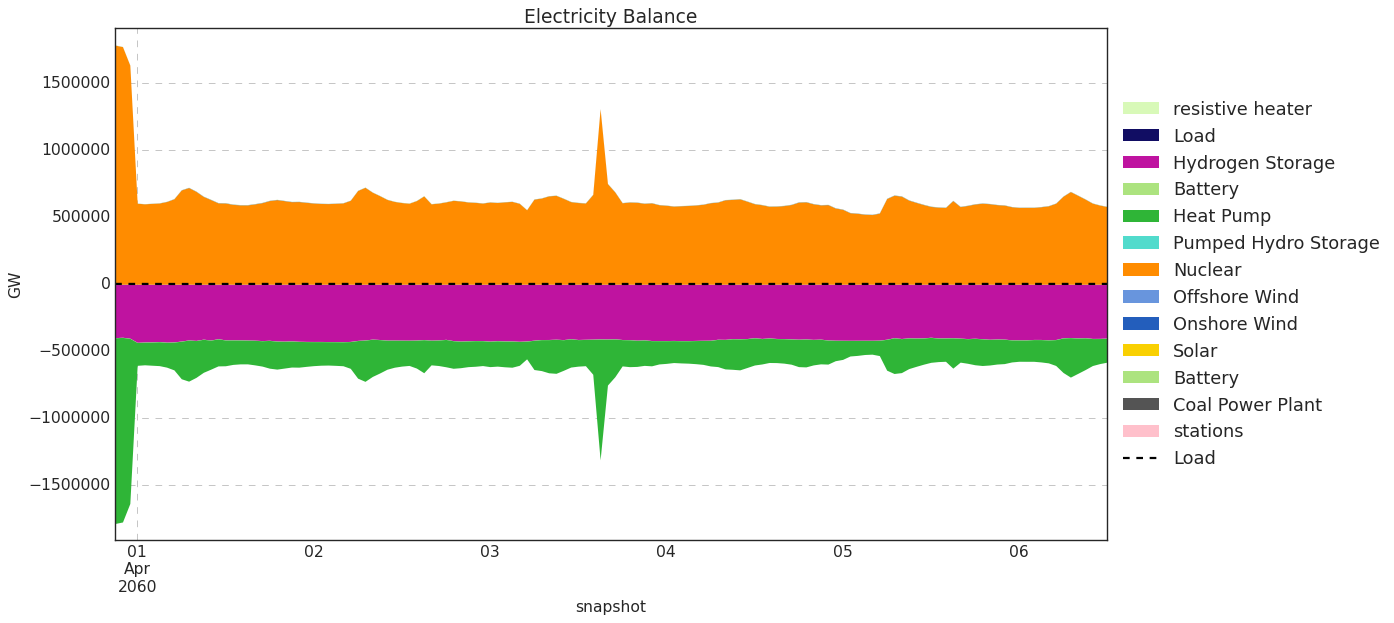

In [39]:
ax = plot_energy_balance(n, config["plotting"], start_date="2060-03-31 21:00", end_date="2060-04-06 12:00:00")
ax.grid(axis='y')
ax.set_title("Electricity Balance")

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1798: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, None)


Text(0.5, 1.0, 'Heat balance')

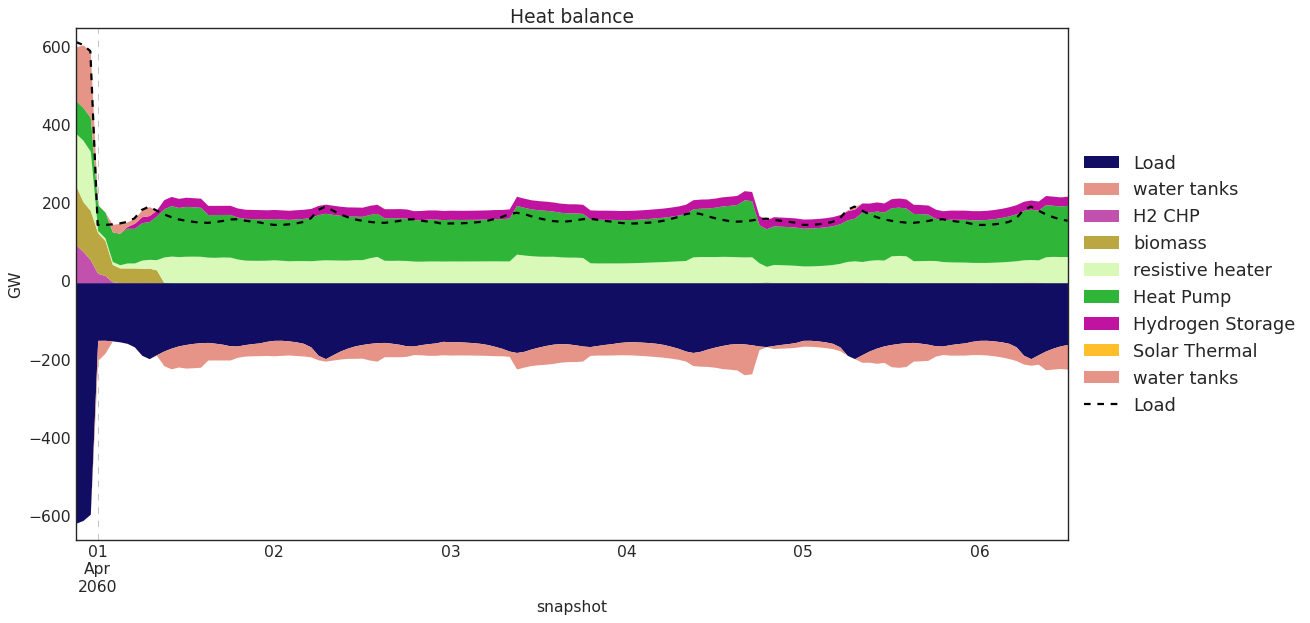

In [ ]:
ax = plot_energy_balance(n, config["plotting"], start_date="2060-03-31 21:00", end_date="2060-04-06 12:00:00", bus_carrier="heat")
ax.set_title("Heat balance")

Text(0, 0.5, 'EnergyDemand / GW')

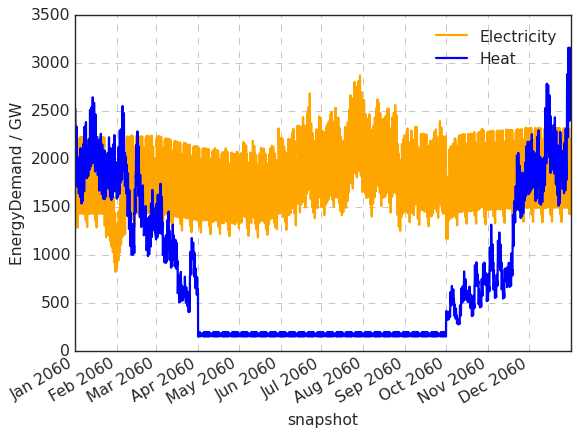

In [ ]:
fix, ax = plt.subplots()
ds_AC = n.statistics.withdrawal(bus_carrier="AC", aggregate_time=False).loc[("Load", "-")]/1e3
ds_heat = n.statistics.withdrawal(bus_carrier="heat", aggregate_time=False).loc[("Load", "-")]/1e3
ds_AC.plot(ax=ax, label="Electricity",  c="orange")
ds_heat.plot(ax=ax, label="Heat", c = "blue")
ax.legend()
ax.set_ylabel("EnergyDemand / GW")

In [ ]:
capacity_factors = n.statistics.capacity_factor(aggregate_time=False).loc[["Generator"]].droplevel(0).T

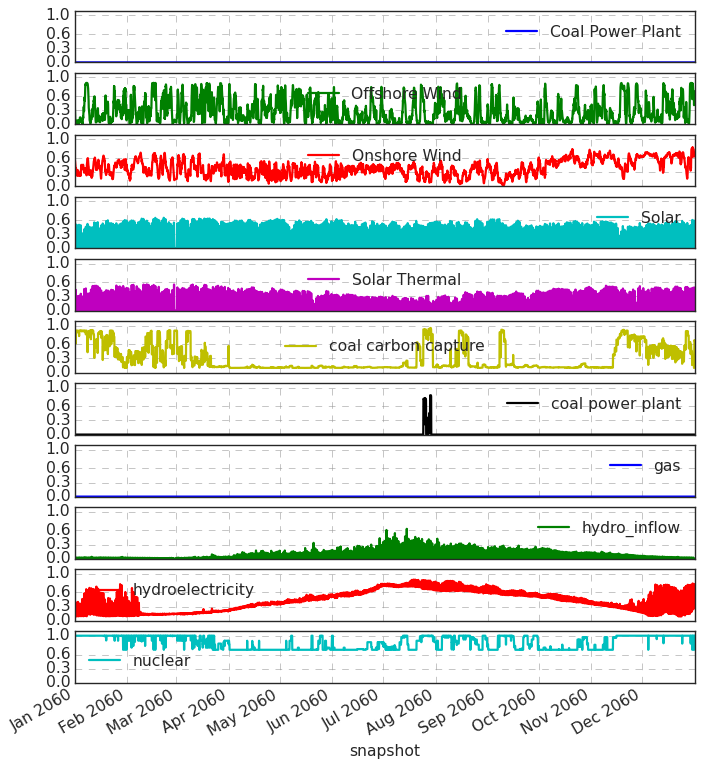

In [ ]:
axes = capacity_factors.dropna(axis=1, how="all").fillna(0).plot(subplots=True, figsize=(10,12))
for ax in axes:
    ax.set_ylim([0,1.1])
    ax.set_yticks([0,0.3, 0.6,1])

# Pypsa eur

# Plot time series (dev sandbox)

Text(0, 0.5, 'GW')

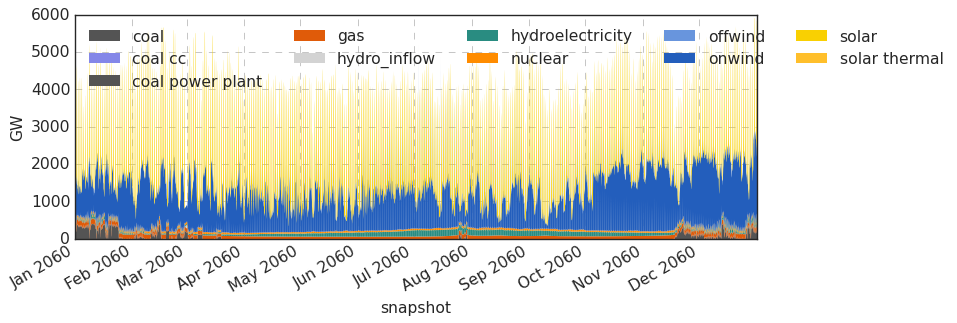

In [ ]:
p_by_carrier = n.generators_t.p.T.groupby(n.generators.carrier).sum().T.div(1e3)
fig, ax = plt.subplots(figsize=(11, 4))

p_by_carrier.plot(
    kind="area",
    ax=ax,
    linewidth=0,
    # cmap="tab20b",
    color = p_by_carrier.columns.map(n.carriers.color),
)

ax.legend(ncol=5, loc="upper left", frameon=False)

ax.set_ylabel("GW")

# ax.set_ylim(0, 80);

# COSTS & prices

In [ ]:
stores_inflow = n.stores_t.p.sum()
h2_stores= stores_inflow.loc[[c for c in stores_inflow.index if c.find("H2 Store")!=-1]]
h2_stores_inflow = h2_stores.where(h2_stores>0,0).sum()
h2_stores_outflow = h2_stores.where(h2_stores<0,0).sum()

# STATS

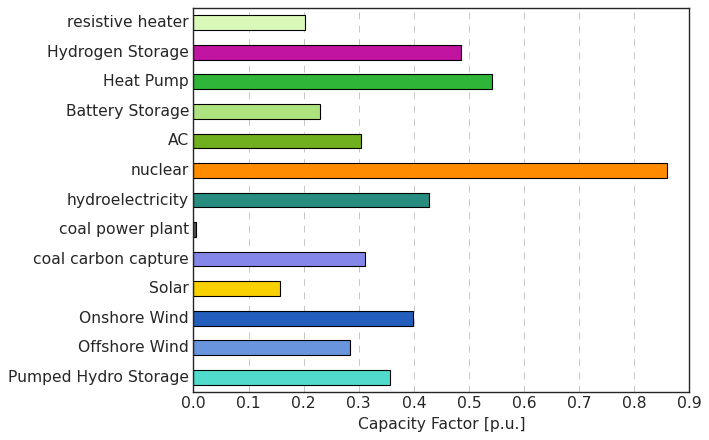

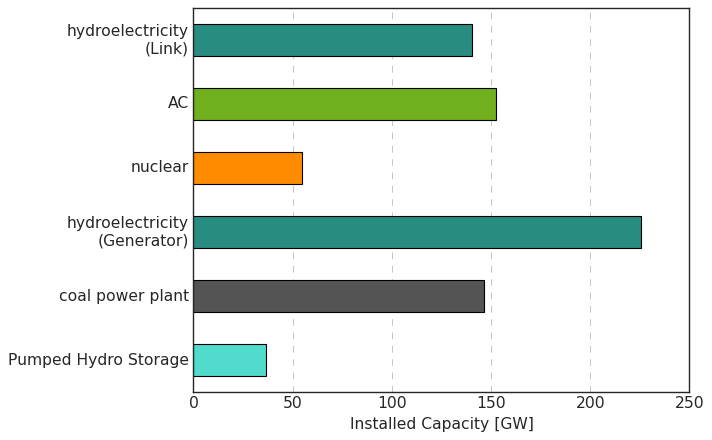

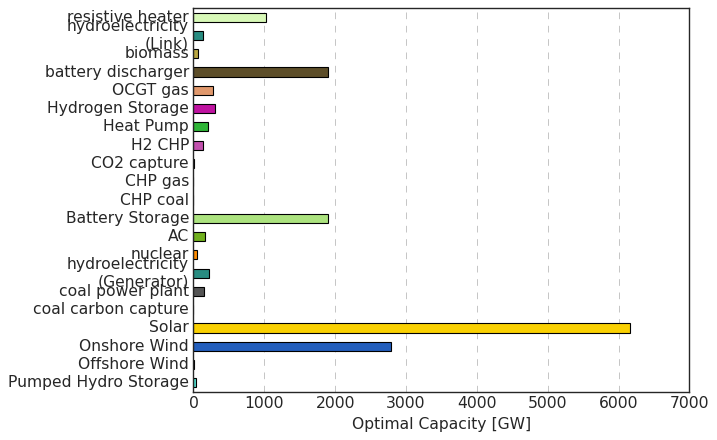

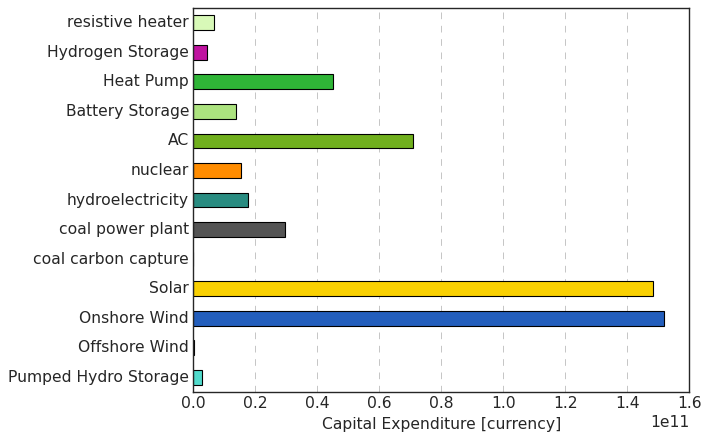

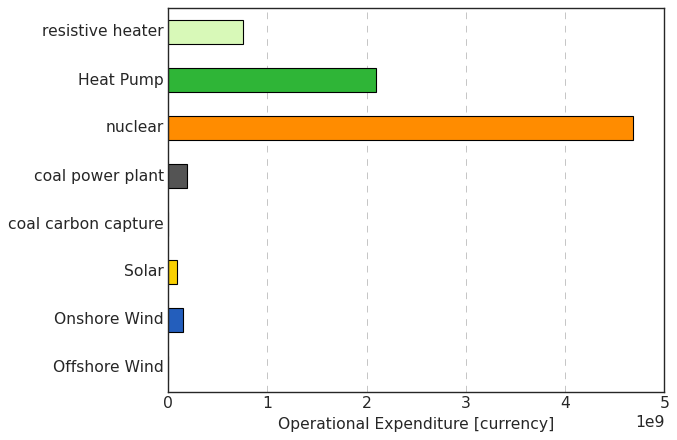

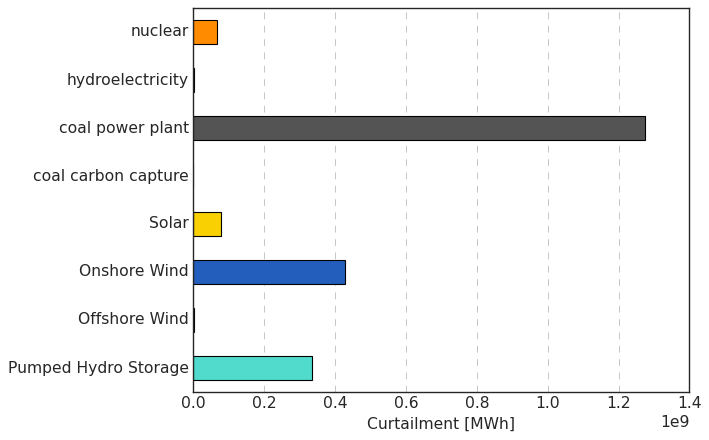

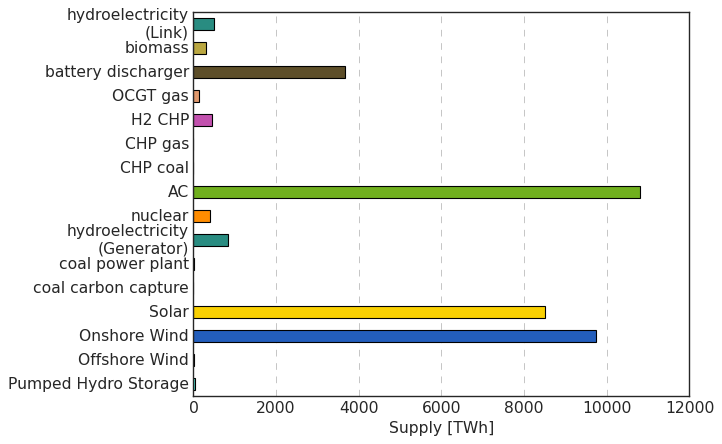

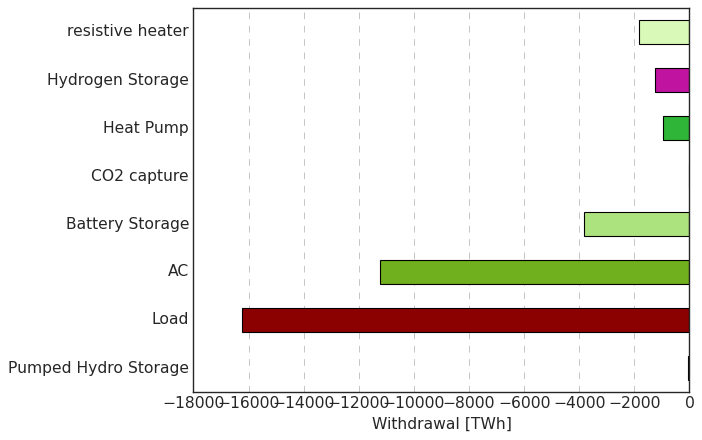

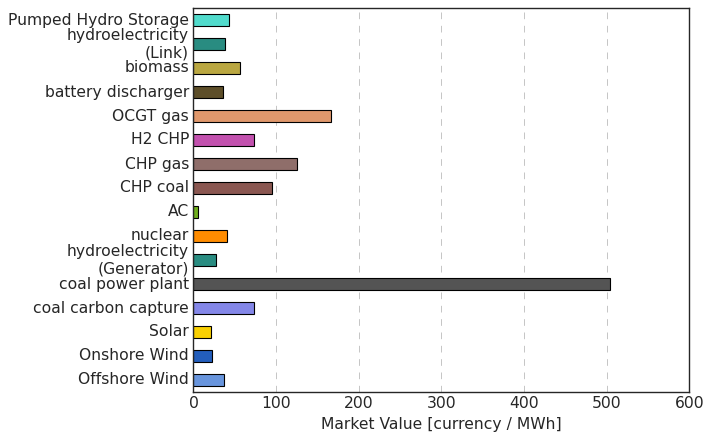

In [ ]:
bus_carrier = "AC"
n.loads.carrier = "load"
n.carriers.loc["load", ["nice_name", "color"]] = "Load", "darkred"
colors = n.carriers.set_index("nice_name").color.where(
    lambda s: s != "", "lightgrey"
)

def rename_index(ds):
    specific = ds.index.map(lambda x: f"{x[1]}\n({x[0]})")
    generic = ds.index.get_level_values("carrier")
    duplicated = generic.duplicated(keep=False)
    index = specific.where(duplicated, generic)
    return ds.set_axis(index)

def plot_static_per_carrier(ds, ax, drop_zero=True):
    if drop_zero:
        ds = ds[ds != 0]
    ds = ds.dropna()
    c = colors[ds.index.get_level_values("carrier")]
    ds = ds.pipe(rename_index)
    label = f"{ds.attrs['name']} [{ds.attrs['unit']}]"
    ds.plot.barh(color=c.values, xlabel=label, ax=ax)
    ax.grid(axis="y")

fig, ax = plt.subplots()
ds = n.statistics.capacity_factor(bus_carrier=bus_carrier).dropna()
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.installed_capacity(bus_carrier=bus_carrier).dropna()
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds.drop(("Generator", "Load"), errors="ignore")
ds = ds / 1e3
ds.attrs["unit"] = "GW"
plot_static_per_carrier(ds.abs(), ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.optimal_capacity(bus_carrier=bus_carrier)
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds.drop(("Generator", "Load"), errors="ignore")
ds = ds.abs() / 1e3
ds.attrs["unit"] = "GW"
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.capex(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.opex(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.curtailment(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.supply(bus_carrier=bus_carrier)
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds / 1e6
ds.attrs["unit"] = "TWh"
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.withdrawal(bus_carrier=bus_carrier)
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds / -1e6
ds.attrs["unit"] = "TWh"
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.market_value(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

In [ ]:
ds = n.statistics.installed_capacity(bus_carrier=bus_carrier).dropna()

ds = ds[ds != 0]
ds = ds.dropna()
c = colors[ds.index.get_level_values("carrier")]
# ds = ds.pipe(rename_index)
# label = f"{ds.attrs['name']} [{ds.attrs['unit']}]"
# ds.plot.barh(color=c.values, xlabel=label, ax=ax)
# ax.grid(axis="y")
ds

component    carrier             
StorageUnit  Pumped Hydro Storage     36390.00000
Generator    coal power plant        146354.00000
             hydroelectricity        225378.00000
             nuclear                  54647.00000
Link         AC                     -152252.22609
             hydroelectricity        140322.00000
dtype: float64

# Network topology

In [ ]:
n.determine_network_topology()
n.sub_networks["n_branches"] = [
    len(sn.branches()) for sn in n.sub_networks.obj
]
n.sub_networks["n_buses"] = [len(sn.buses()) for sn in n.sub_networks.obj]

n.sub_networks



,carrier,slack_bus,obj,n_branches,n_buses
SubNetwork,,,,,
0,AC,Anhui,<pypsa.components.SubNetwork object at 0x7ff2e...,0,1
1,AC,Beijing,<pypsa.components.SubNetwork object at 0x7ff2f...,0,1
2,AC,Chongqing,<pypsa.components.SubNetwork object at 0x7ff2f...,0,1
3,AC,Fujian,<pypsa.components.SubNetwork object at 0x7ff2f...,0,1
4,AC,Gansu,<pypsa.components.SubNetwork object at 0x7ff2f...,0,1
...,...,...,...,...,...
410,battery,Tianjin battery,<pypsa.components.SubNetwork object at 0x7ff2f...,0,1
411,battery,Tibet battery,<pypsa.components.SubNetwork object at 0x7ff2f...,0,1
412,battery,Xinjiang battery,<pypsa.components.SubNetwork object at 0x7ff2f...,0,1


# EXAMPLES